In [94]:
import pandas as pd
import numpy as np
# 함수 파일 import
import import_ipynb
from function_file import *
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
data=pd.read_csv(r"C:\Users\USER\Desktop\건우\fat_predict_project\data\public_health_data_csv\profiling용.csv")

In [95]:
data=data.drop('fat', axis=1)

타겟변수 분포 확인

c:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DW_WBT_pFT', ylabel='Density'>

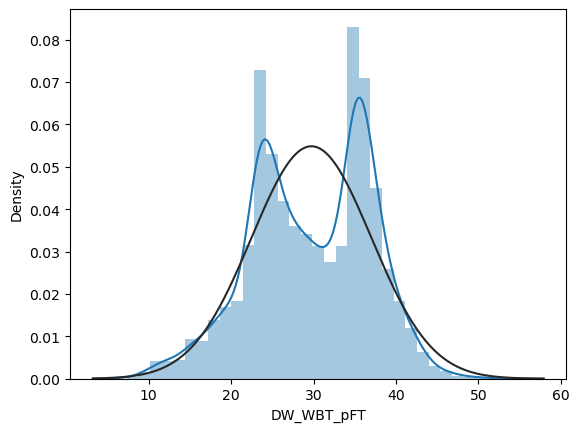

In [96]:
import seaborn as sns
from scipy import stats
from scipy.stats import norm

# distplot : 연속형 데이터의 분포를 보여주는 함수
# fit = norm -> "이 데이터가 정규분포를 따를때의 모습을 보여줌"
# => 정규분포하는지 아닌지 판단 
sns.distplot(data['DW_WBT_pFT'],fit = norm)

((array([-3.58618179, -3.34781938, -3.21628847, ...,  3.21628847,
          3.34781938,  3.58618179]),
  array([ 7.33578995,  7.98679436,  8.07229527, ..., 50.05088224,
         50.67885843, 53.79194459])),
 (7.198492303735369, 29.733583551916897, 0.9890124879381219))

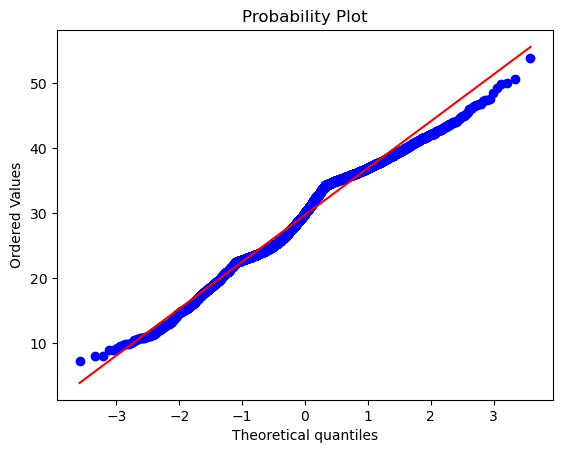

In [97]:
stats.probplot(data['DW_WBT_pFT'], plot=plt)

-     '5.feature_filterling.ipynb' 에서 만든 특성 list import

In [98]:
import pickle

# 순서 적용해서 분류한 특성 리스트
with open('total_list.pkl', 'rb') as f:
    total_list = pickle.load(f)

for i in total_list:
    print(i)

continuous_columns
['N_WATER', 'N_FAT', 'age', 'HE_ht', 'N_INTK', 'HE_wt', 'N_EN', 'N_CHO', 'HE_wc', 'DW_WBT_pFT', 'BP8', 'DW_WBT_BMD', 'N_PROT']
category_columns
['BO1_1', 'BO1_3', 'sex', 'BO3_07', 'fat', 'DI1_2', 'BO3_09', 'BO3_12', 'DI1_dg', 'EC1_1', 'BO3_05', 'BO2_1', 'BO3_04', 'BO3_02', 'N_DIET', 'BO3_03', 'BO3_01']


In [99]:
continuous_columns= total_list[1]
# 타겟변수는 연속형에서 제외
continuous_columns.remove('DW_WBT_pFT')
category_columns=total_list[3]
category_columns.remove('fat')

# (2) Modeling

-     1. 카테고리형 변수 원핫 인코딩

In [100]:
# category_columns 원핫인코딩
one_hot_list=category_columns
for i in one_hot_list:
    data[i] = data[i].astype(str)

In [101]:
# 원핫인코딩 적용한 데이터 프레임
encoded_data=pd.get_dummies(data[one_hot_list])

-     2. 연속형 변수 min_max_scaling 

In [102]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max Scaler 객체 생성
scaler = MinMaxScaler()

# 선택한 컬럼들에 Min-Max Scaling 적용
data[continuous_columns] = scaler.fit_transform(data[continuous_columns])

In [103]:
# 원핫인코딩한 데이터프레임, 연속형특성 데이터프레임, 타겟변수 데이터프레임 병합
data=pd.concat((encoded_data, data[continuous_columns], data['DW_WBT_pFT']), axis=1)

-     3. 모델링 

In [104]:
y = data['DW_WBT_pFT']
X = data.drop(['DW_WBT_pFT','DW_WBT_BMD'], axis=1)

In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

CV Fold 1 - MAE: 2.8005, RMSE: nan, MSE: 13.4079
CV Fold 2 - MAE: 2.9215, RMSE: nan, MSE: 14.4542
CV Fold 3 - MAE: 2.7734, RMSE: nan, MSE: 13.1105
CV Fold 4 - MAE: 2.9604, RMSE: nan, MSE: 14.9253
CV Fold 5 - MAE: 3.0948, RMSE: nan, MSE: 16.8528
MAE 평균: 2.910127648392071
RMSE 평균: 3.8105875420375783
MSE 평균: 14.550145771753899
MSE 표준편차: 1.328876898826837
['sex_1', 'HE_wc', 'BO2_1_1.0', 'BO1_1_3.0', 'HE_wt', 'DI1_2_8.0', 'BO2_1_3.0', 'HE_ht', 'EC1_1_1.0', 'BO1_1_2.0', 'BO3_01_1.0', 'age', 'BO2_1_2.0', 'N_CHO', 'N_INTK', 'N_FAT', 'BO3_12_1.0', 'N_DIET_1.0', 'N_PROT', 'BO1_1_1.0', 'BO3_04_1.0', 'BO1_3_3.0', 'N_EN', 'BO3_02_1.0', 'DI1_dg_0.0', 'BO3_05_1.0', 'BP8', 'BO3_01_0.0', 'N_WATER', 'BO3_03_1.0']


<string>:11: RuntimeWarning: invalid value encountered in sqrt


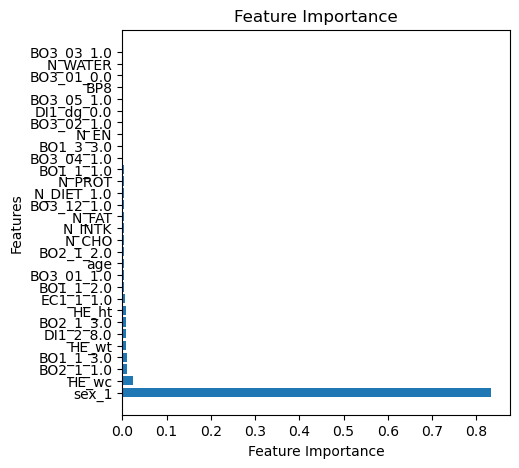

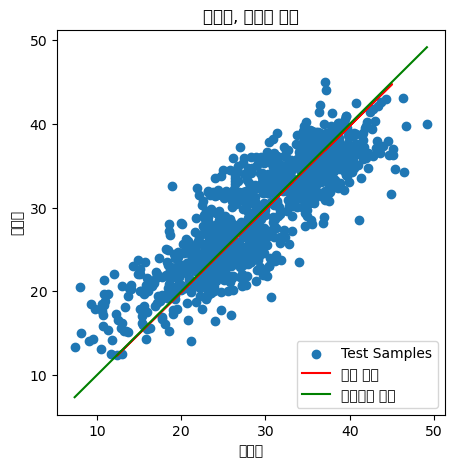

In [106]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# XGBoost 모델
model_XGBoost = xgb.XGBRegressor(max_depth=3, n_estimators=600, learning_rate=0.1)
model_XGBoost.fit(X_train, y_train)
model_val(model_XGBoost, X_train, y_train)
feature_importance(model_XGBoost, X_train, 30)
visualize_model_predictions(model_XGBoost, X_test, y_test)

CV Fold 1 - MAE: 2.8592, RMSE: nan, MSE: 14.0031
CV Fold 2 - MAE: 2.9589, RMSE: nan, MSE: 14.7350
CV Fold 3 - MAE: 2.7990, RMSE: nan, MSE: 13.5917
CV Fold 4 - MAE: 2.9474, RMSE: nan, MSE: 14.5014
CV Fold 5 - MAE: 3.0970, RMSE: nan, MSE: 16.7857
MAE 평균: 2.9323159749733803
RMSE 평균: 3.8344959096647564
MSE 평균: 14.723365302419225
MSE 표준편차: 1.1047323782796763
['sex_1', 'HE_wc', 'sex_2', 'HE_wt', 'HE_ht', 'N_FAT', 'N_PROT', 'age', 'N_CHO', 'N_WATER', 'N_INTK', 'N_EN', 'BO2_1_1.0', 'BP8', 'BO1_1_3.0', 'BO1_1_2.0', 'BO2_1_3.0', 'EC1_1_2.0', 'BO3_01_0.0', 'EC1_1_1.0', 'N_DIET_2.0', 'BO1_3_8.0', 'DI1_2_8.0', 'DI1_dg_0.0', 'DI1_2_1.0', 'BO1_1_1.0', 'BO3_04_1.0', 'BO2_1_2.0', 'BO3_12_1.0', 'BO3_03_1.0']


<string>:11: RuntimeWarning: invalid value encountered in sqrt


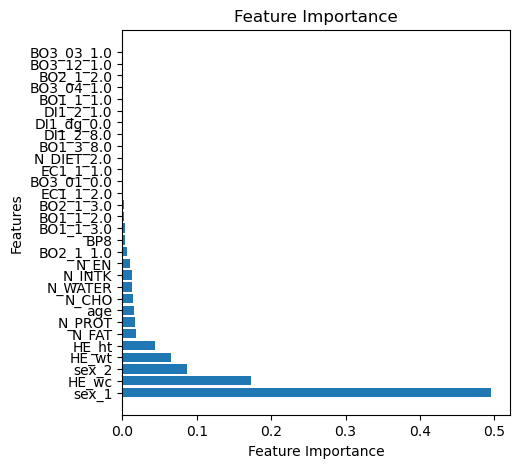

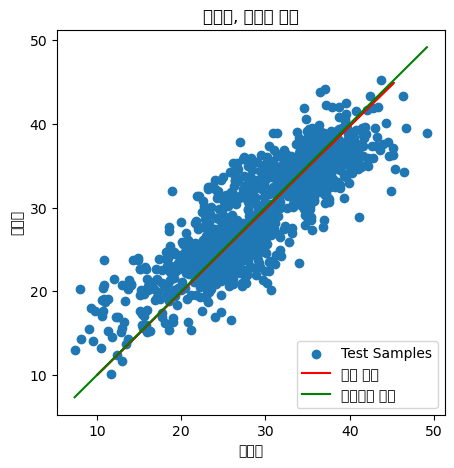

In [107]:
# Gradient Boosting 모델
model_Gradient = GradientBoostingRegressor(max_depth=3, n_estimators=600, learning_rate=0.1)
model_Gradient.fit(X_train, y_train)
#교차검증 함수
model_val(model_Gradient, X_train, y_train)
#중요도 시각화
feature_importance(model_Gradient, X_train, 30)
visualize_model_predictions(model_Gradient, X_test, y_test)